In [1]:
import pickle
from tkinter import filedialog, messagebox
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt



def carregar_modelo(nome_arquivo):
    try:
        with open(nome_arquivo, 'rb') as arquivo:
            model = pickle.load(arquivo)
        print(f"Modelo carregado com sucesso de {nome_arquivo}.")
        return model
    except FileNotFoundError:
        print(f"Erro: O arquivo {nome_arquivo} não foi encontrado.")
        return None
    except Exception as e:
        print(f"Erro ao carregar o modelo: {e}")
        return None

In [2]:
def process_data(hex_data):
    # Verifica se a entrada é uma string
    if isinstance(hex_data, str):
        byte_list = hex_data.split(' ')

        # Verifica se a lista contém exatamente 8 itens
        if len(byte_list) < 8:
            byte_list.extend(['00'] * (8 - len(byte_list)))

        # Converte os valores de hexadecimal para decimal
        byte_list = [int(byte, 16) for byte in byte_list]

        return byte_list  # Retorna a lista para ser expandida em colunas
    else:
        raise ValueError("A entrada deve ser uma string hexadecimal.")


In [3]:
def ixxt_filetodataframe(file_path):
    df = pd.read_csv(file_path, sep=';', quotechar='"', skiprows=6)
    df = df.dropna(subset=['Data (hex)'])
    df['Identifier (hex)'] = df['Identifier (hex)'].apply(lambda x: int(x, 16))

    byte_columns = df['Data (hex)'].apply(process_data)
    
    byte_columns = pd.DataFrame(byte_columns.tolist(), index=df.index, columns=[f'byte_{i + 1}' for i in range(8)])
    print(byte_columns)
    columns_to_drop = ['Format', 'Flags', 'Time', 'Data (hex)']
    df = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
    df = pd.concat([df, byte_columns], axis=1)
    df = df.rename(columns={'Identifier (hex)': 'pgn'})
    return df


In [4]:
def ui_load_ixxt_archive(file_path):
    # Se o caminho não for fornecido, abrir a caixa de diálogo para selecionar o arquivo
    if not file_path:
        file_path = filedialog.askopenfilename(
            title="Selecione o arquivo CSV",
            filetypes=(("CSV files", "*.CSV"), ("all files", "*.*"))
        )
    
    # Verificar se o caminho foi fornecido ou selecionado
    if file_path:
        df = ixxt_filetodataframe(file_path)  # Simulação do carregamento de dados
        return df
    else:
        print("Nenhum arquivo foi selecionado.")
        return None

In [5]:
# Função para verificar se uma coluna tem valores constantes
def coluna_eh_constante(coluna):
    return len(np.unique(coluna)) == 1

In [6]:
def analyse_archive(df):
    data_list = []

    # Exibir as primeiras linhas do DataFrame para verificar a estrutura
    print("Primeiras linhas do DataFrame:")
    print(df.head())

    # Iterar sobre cada PGN único no DataFrame
    for pgn in df['pgn'].unique():
        df_pgn = df[df['pgn'] == pgn].copy()  # Filtrar o DataFrame para o PGN atual
        
        print(f"\nAnalisando PGN: {pgn}")
        print("Primeiras linhas do DataFrame para este PGN:")
        print(df_pgn.head())  # Exibir o DataFrame filtrado por PGN

        # Iterar sobre as colunas de bytes (de 'byte_1' até 'byte_8')
        for i in range(1, 9):  # Para os bytes de 1 a 8
            byte_column = f'byte_{i}'  # Supondo que os bytes estão nomeados como byte_1, byte_2, ..., byte_8
            
            # Verificar se a coluna existe no DataFrame
            if byte_column not in df_pgn.columns:
                print(f"{byte_column} não encontrada no DataFrame.")
                continue

            # Verificar se a coluna tem valores constantes e descartar se tiver
            if coluna_eh_constante(df_pgn[byte_column]):
                print(f"{byte_column} descartada por ser constante.")
                continue
            
            print(f"Processando {byte_column}")
            
            # Obter os valores de cada byte
            X = df_pgn[byte_column].values

            if len(X) > 1:  # Garantir que temos dados suficientes
                # Armazenar os dados para processamento posterior
                data_list.append({'pgn': pgn, 'byte_column': byte_column, 'data': X})
            else:
                print(f"Dados insuficientes em {byte_column} para PGN {pgn}.")

    # Criar um DataFrame com os dados coletados
    data_df = pd.DataFrame(data_list)

    return data_df


In [7]:
def prepare_sequences(data_df, target_size=1200):
    validated_pgns = []

    for index, row in data_df.iterrows():
        pgn = row['pgn']
        byte_column = row['byte_column']
        sequence = row['data']

        # Ajustar o tamanho da sequência usando duplicação ou decimação
        if len(sequence) != target_size:
            if len(sequence) > target_size:
                # Aplicar decimação dinâmica
                adjusted_sequence = decimacao_dinamica(sequence, target_size)
            else:
                # Aplicar duplicação de valores individualmente
                adjusted_sequence = duplicar_valores_individualmente(sequence, target_size)
        else:
            adjusted_sequence = sequence

        # Converter a sequência ajustada para 2D se necessário
        adjusted_sequence = adjusted_sequence.reshape(-1, 1)

        validated_pgns.append({'pgn': pgn, 'byte_column': byte_column, 'sequence': adjusted_sequence})

    # Converter para DataFrame
    validated_df = pd.DataFrame(validated_pgns)

    return validated_df


In [8]:
def decimacao_dinamica(array, target_size):
    array = np.array(array).flatten()
    current_size = len(array)

    if current_size <= target_size:
        return array  # Não precisa decimar

    step = max(current_size // target_size, 1)
    decimated_array = array[::step][:target_size]
    return decimated_array

In [9]:
def classify_sequences(model, validated_df):
    classified_results = []

    for index, row in validated_df.iterrows():
        pgn = row['pgn']
        byte_column = row['byte_column']
        sequence = row['sequence']

        # Fazer predições para a sequência
        y_pred = model.predict(sequence)

        # Calcular a acurácia (ou outro critério relevante)
        accuracy = np.mean(y_pred)

        classified_results.append({'pgn': pgn, 'byte_column': byte_column, 'accuracy': accuracy, 'predictions': y_pred})

    # Converter para DataFrame
    classified_df = pd.DataFrame(classified_results)

    return classified_df


In [10]:
def validate_peaks(classified_df):
    processed_results = []

    for index, row in classified_df.iterrows():
        pgn = row['pgn']
        byte_column = row['byte_column']
        accuracy = row['accuracy']
        sequence = row['predictions']

        # Garantir que a sequência seja um array 1D
        seq = sequence.flatten()

        # Realizar análise de picos
        peaks, _ = find_peaks(seq)
        num_peaks = len(peaks)

        # Verificar o número de picos
        if 3 <= num_peaks <= 8:
            # Manter este PGN
            processed_results.append({'pgn': pgn, 'byte_column': byte_column, 'accuracy': accuracy, 'num_peaks': num_peaks, 'sequence': sequence})
        else:
            # Descartar este PGN
            print(f"PGN {pgn}, {byte_column} descartado por ter {num_peaks} picos.")

    # Converter para DataFrame
    processed_df = pd.DataFrame(processed_results)

    return processed_df

In [11]:

def plot_best_pgns(best_results_df):
    for index, row in best_results_df.iterrows():
        pgn = row['pgn']
        byte_column = row['byte_column']
        accuracy = row['accuracy']
        sequence = row['sequence'].flatten()  # Ensure sequence is 1D

        plt.figure(figsize=(10, 6))
        plt.plot(sequence, label=f"PGN {pgn}, {byte_column} (Acurácia: {accuracy:.2f})")
        plt.xlabel('Timestep')
        plt.ylabel('Valor')
        plt.title(f"Melhor sequência para PGN {pgn}, {byte_column}")
        plt.legend()
        plt.show()


In [12]:
def duplicar_valores_individualmente(array, target_size):
    array = np.array(array).flatten()  # Achata a array para 1D
    current_size = len(array)

    if current_size >= target_size:
        return array[:target_size]  # Se já tiver o tamanho ou maior, trunca a array

    # Calcula o número de repetições por valor como um número de ponto flutuante
    repeats_per_value = target_size / current_size

    # Lista para armazenar o número de repetições para cada valor
    repeats = []
    cumulative_error = 0.0

    for i in range(current_size):
        # Calcula o número de repetições para este valor
        repeat = int(repeats_per_value)
        cumulative_error += (repeats_per_value - repeat)

        # Ajusta a repetição quando o erro acumulado excede 1
        if cumulative_error >= 1.0:
            repeat += 1
            cumulative_error -= 1.0

        repeats.append(repeat)

    # Ajusta o total de repetições para corresponder ao tamanho alvo
    total_repeats = sum(repeats)
    index = 0
    while total_repeats < target_size:
        repeats[index % current_size] += 1
        total_repeats += 1
        index += 1
    while total_repeats > target_size:
        repeats[index % current_size] -= 1
        total_repeats -= 1
        index += 1

    # Repete cada valor de acordo com o número calculado
    repeated_array = np.repeat(array, repeats)

    return repeated_array


In [13]:
def process_best_pgns(best_pgns):
    # Organizar best_pgns por ordem decrescente de acurácia
    best_pgns_sorted = sorted(best_pgns, key=lambda x: x[2], reverse=True)
    
    processed_pgns = []
    
    for pgn in best_pgns_sorted:
        pgn_number, byte_column, accuracy, sequence = pgn
        
        # Garantir que a sequência seja um array 1D
        seq = sequence.flatten()
        
        # Realizar análise de picos
        peaks, _ = find_peaks(seq)
        num_peaks = len(peaks)
        
        # Verificar o número de picos
        if 3 <= num_peaks <= 8:
            # Manter este pgn
            processed_pgns.append(pgn)
        else:
            # Descartar este pgn
            print(f"PGN {pgn_number}, {byte_column} descartado por ter {num_peaks} picos.")
    
    return processed_pgns


In [14]:
df = ui_load_ixxt_archive('KALMAR DRG540-65/LIMPADOR 5x.CSV') 

model = carregar_modelo("meu_modelo.pkl")

best_pgns = analyse_archive(df)

       byte_1  byte_2  byte_3  byte_4  byte_5  byte_6  byte_7  byte_8
0           0       0       0       0       0       0       0       0
1           2      80     154       9       0       0       0       0
2           7     211       0      31       0       0       0       0
3           0       0       0       0       0       3       0       0
4         125       0       0       0       0      16       0       0
...       ...     ...     ...     ...     ...     ...     ...     ...
18243      11     173     178      51       0       0       0       0
18244      12       0     217      27       0       0       0       0
18245       2      80     154       9       0       0       0       0
18246     160      19     124       5     197      12     108      16
18247      96       0       0       0       0     144       1       0

[18248 rows x 8 columns]
Modelo carregado com sucesso de meu_modelo.pkl.
Primeiras linhas do DataFrame:
    pgn  byte_1  byte_2  byte_3  byte_4  byte_5  byte_6

       byte_1  byte_2  byte_3  byte_4  byte_5  byte_6  byte_7  byte_8
0          93       0       0       0       0       0       0       0
1           0       0       0       0     175     215      70       0
2           0       0       0       0       0       0       0       0
3         255     195       0       7     196       0      32       0
4          25     168      49       0      76      50      49      49
...       ...     ...     ...     ...     ...     ...     ...     ...
16069     127     192       1       0     128       0       0       0
16070      25     128      47       0      76      50      47      47
16071      47      48       0     138       0     161      32       0
16072      50       0     240       0       0       0       0       0
16073     255     195       0       7     110       0      32       0

[16074 rows x 8 columns]
Modelo carregado com sucesso de meu_modelo.pkl.
Primeiras linhas do DataFrame:
    pgn  byte_1  byte_2  byte_3  byte_4  byte_5  byte_6

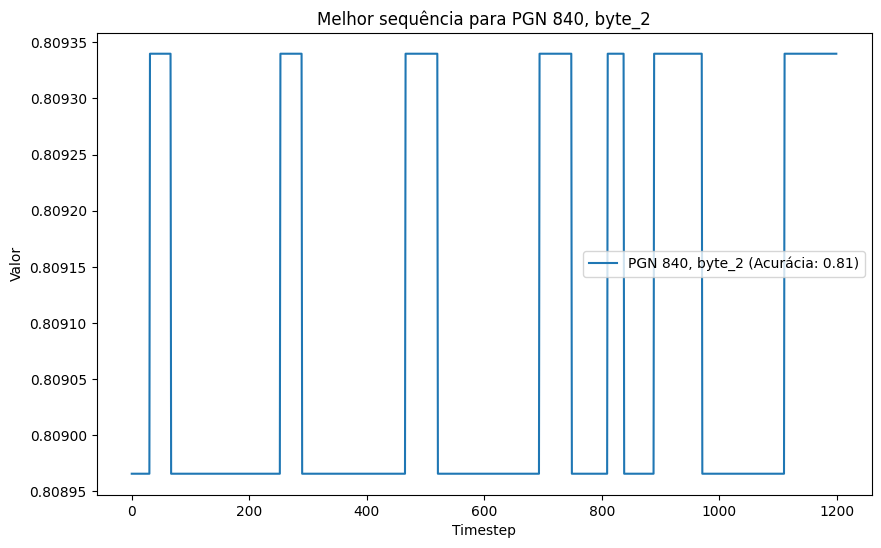

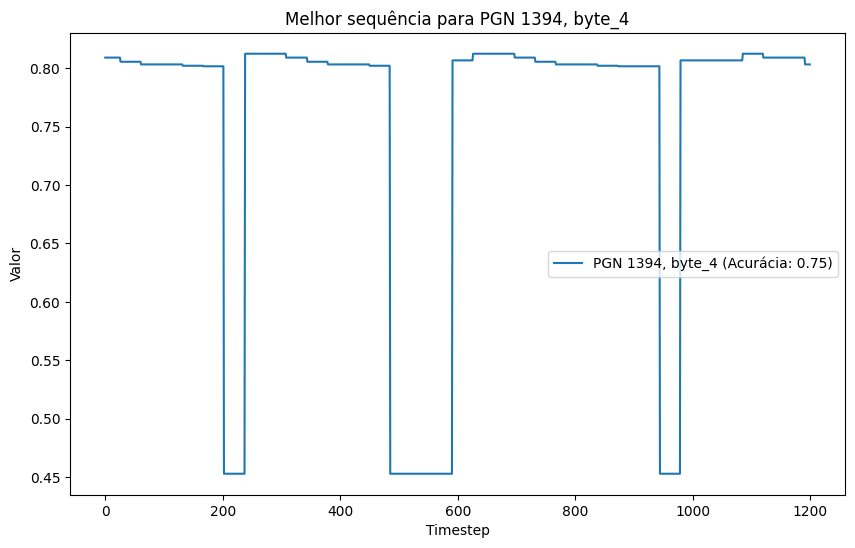

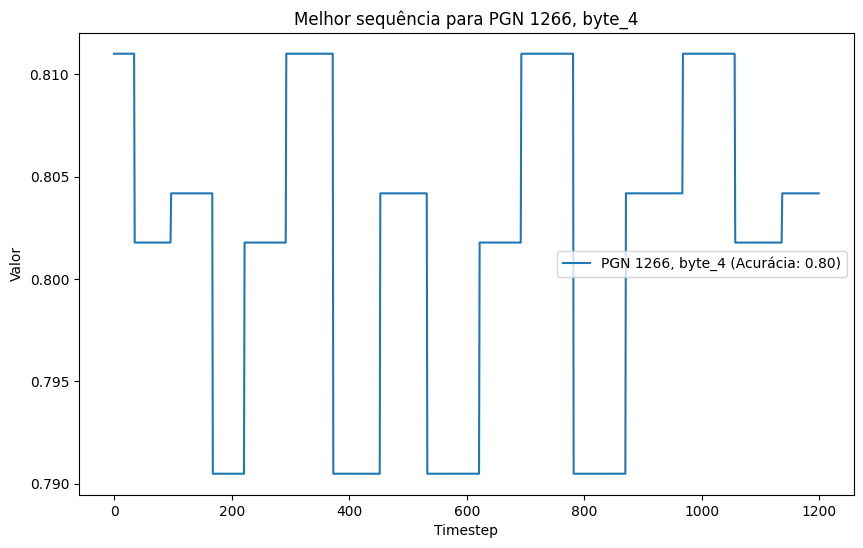

In [15]:
df = ui_load_ixxt_archive('JUMPY 2024/limpador_vel1_5x_jumpy.CSV') 

model = carregar_modelo("meu_modelo.pkl")

# Etapa 1: Analisar o DataFrame e coletar dados após descartar PGNs constantes
data_df = analyse_archive(df)

# Etapa 2: Ajustar as sequências para o tamanho desejado
validated_df = prepare_sequences(data_df, target_size=1200)

# Etapa 3: Classificar as sequências usando o modelo
classified_df = classify_sequences(model, validated_df)

# Etapa 4: Aplicar a validação de picos
final_results_df = validate_peaks(classified_df)

# Opcional: Exibir os resultados finais
print("\nResultados finais após validação de picos:")
for index, row in final_results_df.iterrows():
    print(f"PGN: {row['pgn']}, Byte: {row['byte_column']}, Acurácia: {row['accuracy']}, Número de Picos: {row['num_peaks']}")

plot_best_pgns(final_results_df)

       byte_1  byte_2  byte_3  byte_4  byte_5  byte_6  byte_7  byte_8
0           0       0       0       0       0       0       0       0
1           2      80     154       9       0       0       0       0
2           7     211       0      31       0       0       0       0
3           0       0       0       0       0       3       0       0
4         125       0       0       0       0      16       0       0
...       ...     ...     ...     ...     ...     ...     ...     ...
18243      11     173     178      51       0       0       0       0
18244      12       0     217      27       0       0       0       0
18245       2      80     154       9       0       0       0       0
18246     160      19     124       5     197      12     108      16
18247      96       0       0       0       0     144       1       0

[18248 rows x 8 columns]
Modelo carregado com sucesso de meu_modelo.pkl.
Primeiras linhas do DataFrame:
    pgn  byte_1  byte_2  byte_3  byte_4  byte_5  byte_6

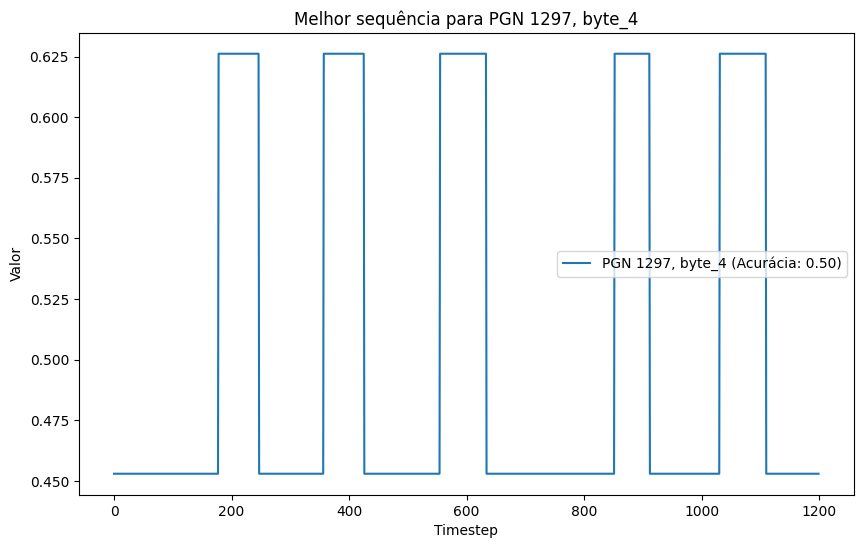

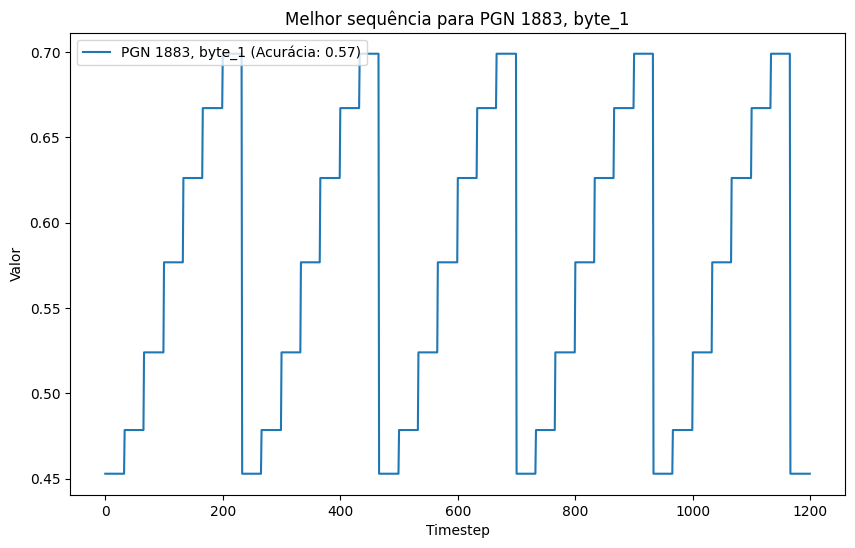

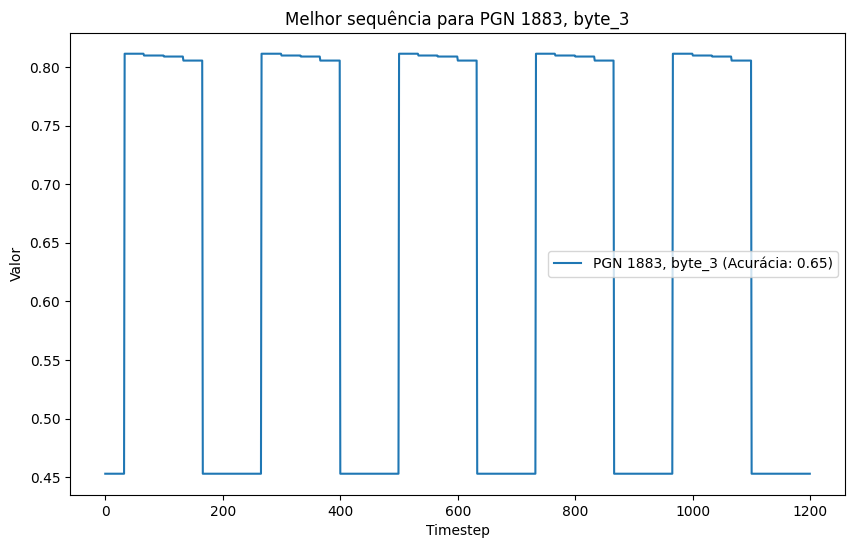

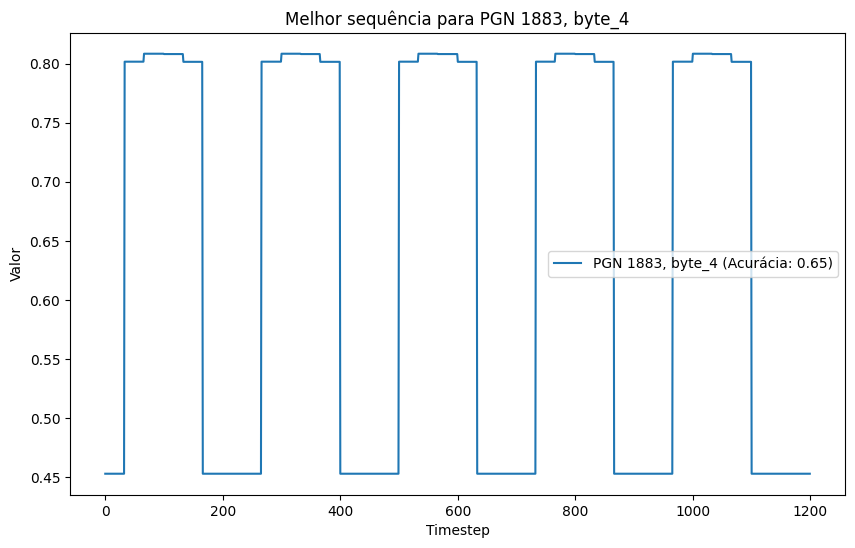

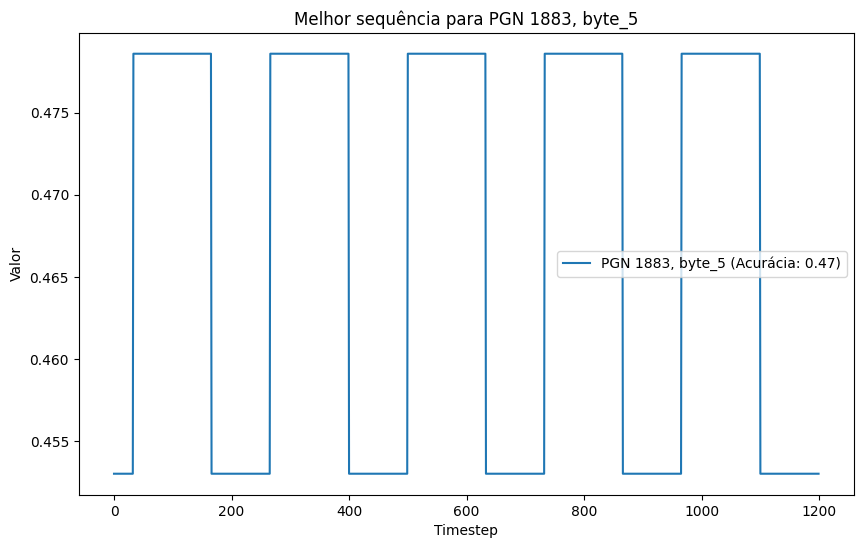

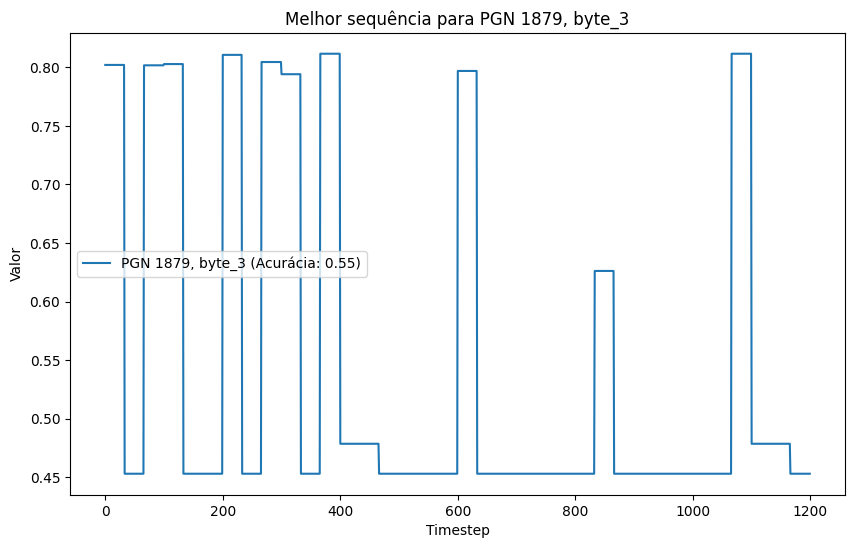

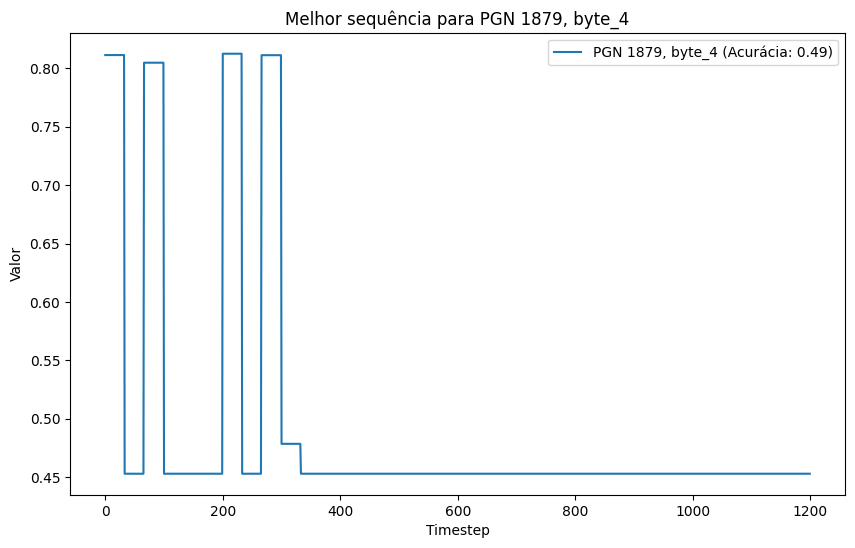

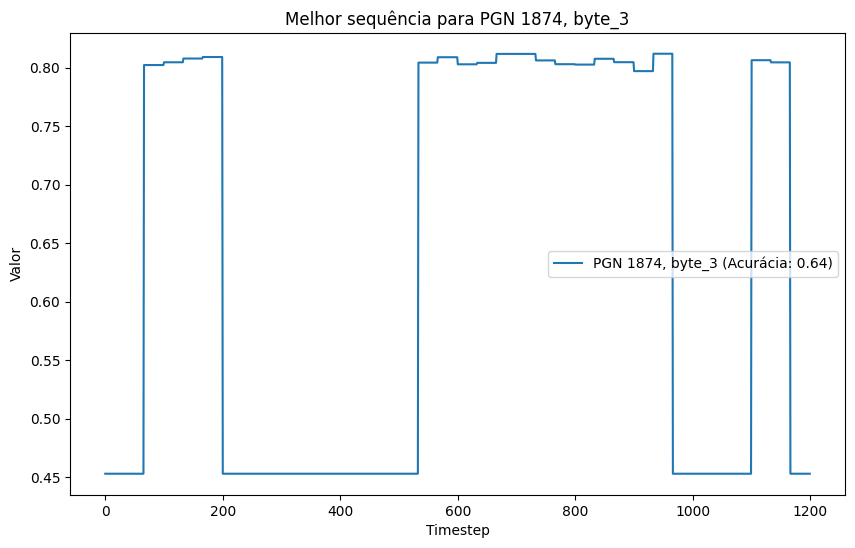

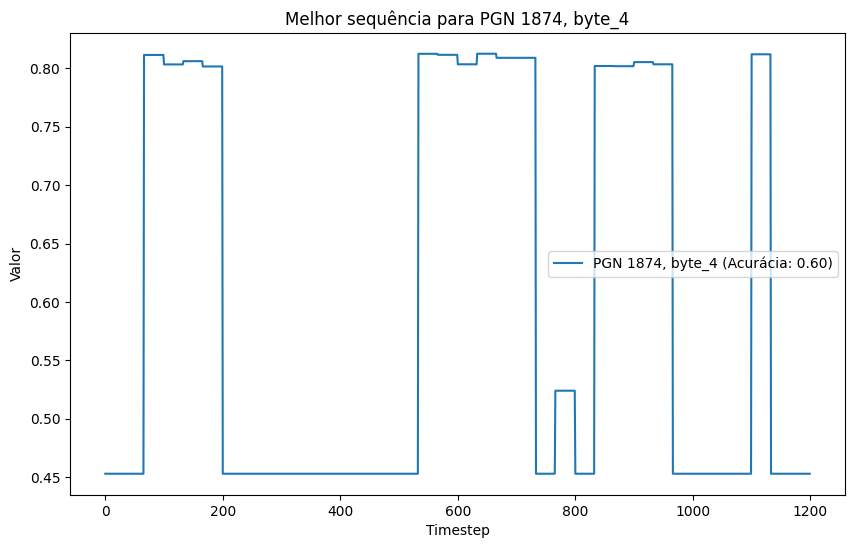

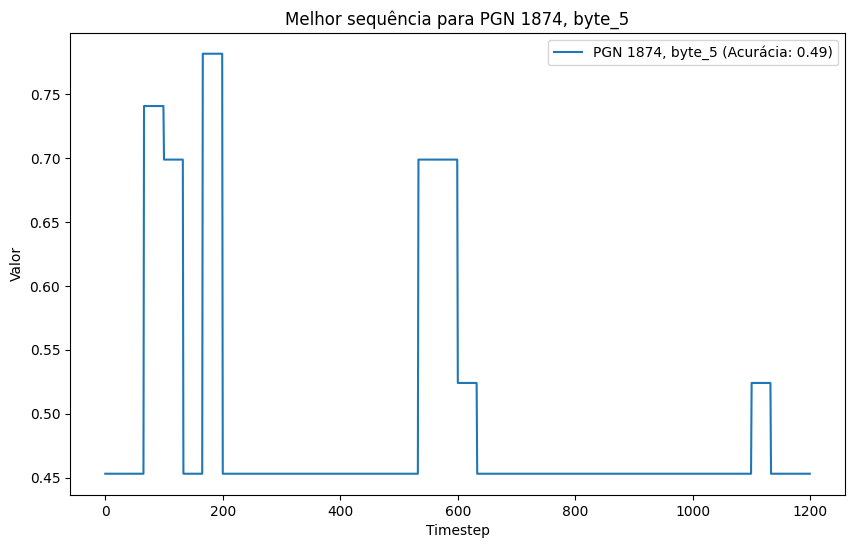

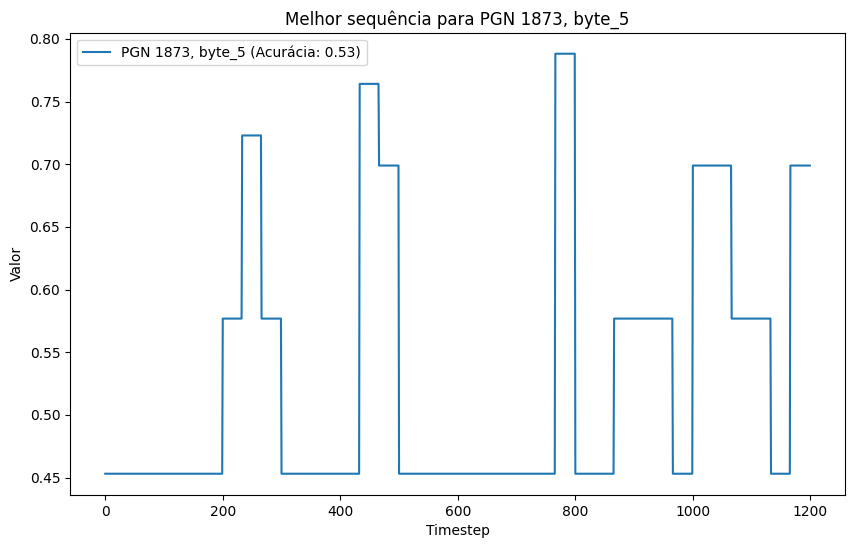

In [16]:
df = ui_load_ixxt_archive('KALMAR DRG540-65/LIMPADOR 5x.CSV')

model = carregar_modelo("meu_modelo.pkl")

# Etapa 1: Analisar o DataFrame e coletar dados após descartar PGNs constantes
data_df = analyse_archive(df)

# Etapa 2: Ajustar as sequências para o tamanho desejado
validated_df = prepare_sequences(data_df, target_size=1200)

# Etapa 3: Classificar as sequências usando o modelo
classified_df = classify_sequences(model, validated_df)

# Etapa 4: Aplicar a validação de picos
final_results_df = validate_peaks(classified_df)

# Opcional: Exibir os resultados finais
print("\nResultados finais após validação de picos:")
for index, row in final_results_df.iterrows():
    print(f"PGN: {row['pgn']}, Byte: {row['byte_column']}, Acurácia: {row['accuracy']}, Número de Picos: {row['num_peaks']}")

plot_best_pgns(final_results_df)